In [1]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

from scipy import interpolate
from scipy import ndimage as ndi

import skimage.data
import skimage.filters
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import register
import utils

im = skimage.data.astronaut()
ORIG_SIZE = (200, 250)
im = np.uint8(255 * skimage.transform.resize(im, ORIG_SIZE))

PADDED_IM_SIZE = (300, 400) 

# try warping 

true_scale = (1.3, .8)
true_rotation = -.3
true_shear = .1
# true_translation = (0, 0)
# true_translation = (30, 30)
true_translation = (20, -40)


aff_tfm = skimage.transform.AffineTransform(
    scale=true_scale,
    rotation=true_rotation,
    shear=true_shear,
    translation=true_translation)

im_fixed = utils.apply_matrix_tform(
    utils.resize_image(im, PADDED_IM_SIZE), aff_tfm)

im_moving = utils.resize_image(im, PADDED_IM_SIZE)

im_fixed_unpadded = utils.apply_matrix_tform(
    utils.resize_image(im, ORIG_SIZE), aff_tfm)


plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

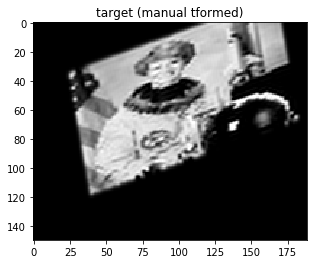

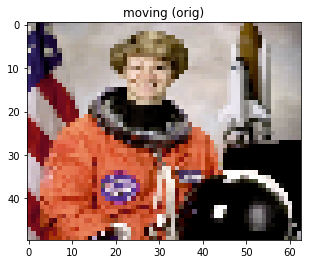

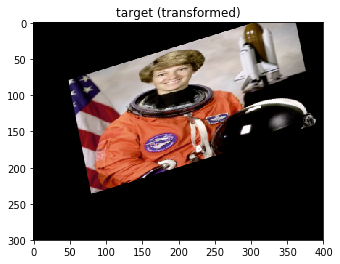

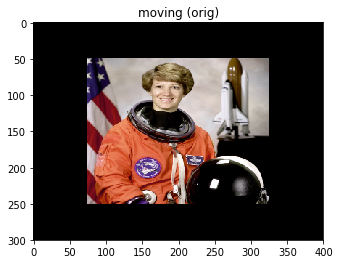

In [34]:
""" RBF
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html
"""

SAMP_SPACE = 4

# resample image
im_moving_sampled = im[::SAMP_SPACE, ::SAMP_SPACE]

# just like in MATLAB, this seems flipped?
# for ranges and grids: x is the columns and y is rows
x_range = np.arange(0, im.shape[1] / SAMP_SPACE)
y_range = np.arange(0, im.shape[0] / SAMP_SPACE)
xx, yy = np.meshgrid(x_range, y_range)
xin, yin = xx.flatten(), yy.flatten()

# list coordinates in input image
xy_in = np.array([xin, yin, np.ones(len(xin))])
shift = np.array([xx.shape[0], xx.shape[1], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))
xy_in = xy_in - shift

# apply transform
tform = aff_tfm.params
tform[0, 2] = tform[0, 2] / SAMP_SPACE
tform[1, 2] = tform[1, 2] / SAMP_SPACE
xy_out = np.dot(tform, xy_in).T
xy_out = xy_out + shift.T

rbf_interp = interpolate.Rbf(
    xy_out[:, 0], xy_out[:, 1], 
    im_moving_sampled[:, :, 0].flatten() / 255.0, 
    function='gaussian', smooth=0.001, epsilon=1)

# # this has to be on a regular grid
x_range_pad = np.linspace(
    -20, im.shape[1] / SAMP_SPACE + 20, xx.shape[1] * 3)
y_range_pad = np.linspace(
    -10, im.shape[0] / SAMP_SPACE + 10, xx.shape[0] * 3)

xx, yy = np.meshgrid(x_range_pad, y_range_pad)
im_new = rbf_interp(xx.flatten(), yy.flatten())
im_new = im_new.reshape(xx.shape)

# im_new = im_new / im_new.max()
im_new = np.clip(im_new, 0, 1)
im_new = np.uint8(255 * im_new)

plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving_sampled)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()


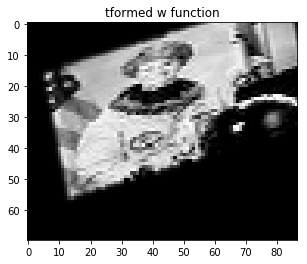

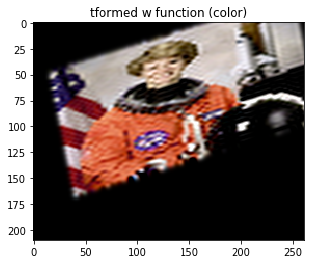

In [35]:
# make a RBF tform based interpolate function

# dx, dy from prev example
dxy = xy_out - xy_in.T
dx, dy = dxy[:, 0], dxy[:, 1]

# pad image (post resizing)
im_orig = im_moving_sampled[:, :, 0]

im_int = register.image_interp_rbf(
    im_orig, dx, dy, pad_pct=0.2, upsample_factor=1)

im_int_3 = register.image_interp_rbf(
    im_moving_sampled, dx, dy, pad_pct=0.2, 
    upsample_factor=3)

plt.figure(1)
plt.title('tformed w function')
plt.imshow(im_int, cmap='gray')

plt.figure(2)
plt.title('tformed w function (color)')
plt.imshow(im_int_3 / 255.0)

plt.show()

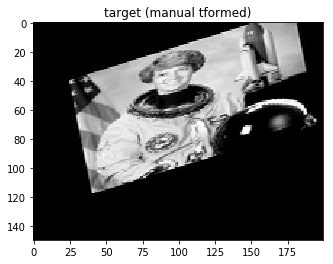

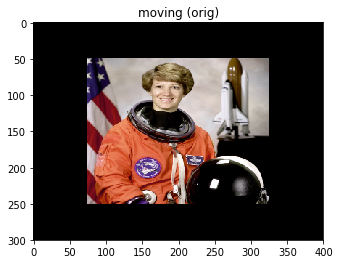

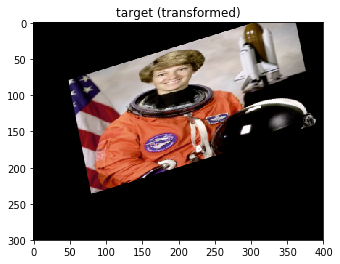

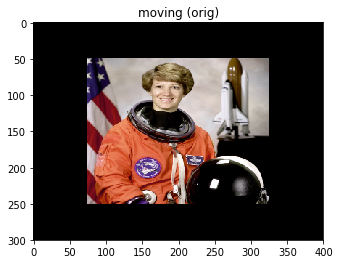

In [5]:
""" warp directly
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp
"""

SAMP_SPACE = 2
# just like in MATLAB, this seems flipped?
# for ranges and grids: x is the columns and y is rows
x_range = np.arange(0, im_moving.shape[1] / SAMP_SPACE)
y_range = np.arange(0, im_moving.shape[0] / SAMP_SPACE)
xx, yy = np.meshgrid(x_range, y_range)

im_moving_sampled = im_moving[::SAMP_SPACE, ::SAMP_SPACE]

xin, yin = xx.flatten(), yy.flatten()

# double checking flattening/reshaping
xx_in_out = np.reshape(xin, xx.shape)
yy_in_out = np.reshape(yin, xx.shape)

assert np.allclose(xx, xx_in_out)
assert np.allclose(yy, yy_in_out)

# list coordinates in input image
shift = np.array([xx.shape[1], xx.shape[0], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))


def trans_xy(xy):
    xy_in = np.array([xy[:, 0], xy[:, 1], np.ones(len(xy))])
    xy_in = xy_in - shift
    
    # apply transform
    tform_inv = np.linalg.inv(aff_tfm.params)
    tform_inv[0, 2] = tform_inv[0, 2] / SAMP_SPACE
    tform_inv[1, 2] = tform_inv[1, 2] / SAMP_SPACE
    
    xy_out = np.dot(tform_inv, xy_in).T
    xy_out = xy_out + shift.T
    
    xy_out =  np.array([xy_out[:, 0], xy_out[:, 1]])
    return xy_out.T


coord = skimage.transform.warp_coords(trans_xy, xx.shape)

im_new = skimage.transform.warp(
    im_moving_sampled[:,:,0] / 255.0, coord,
    order=3, preserve_range=True, mode='constant',
    clip=True
)

# im_new = im_new / im_new.max()
im_new = np.clip(im_new, 0, 1)
im_new = np.uint8(255 * im_new)

plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()


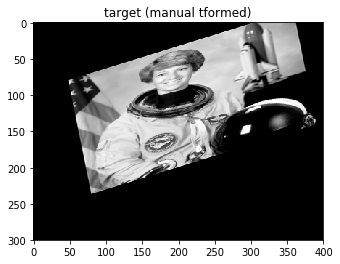

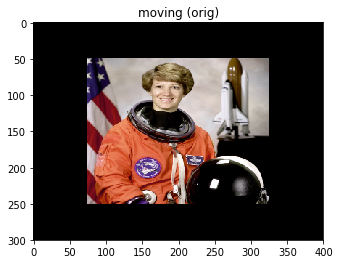

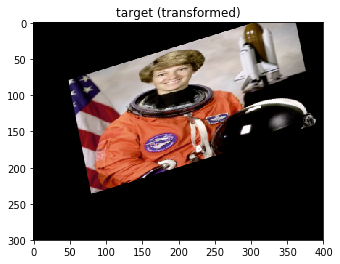

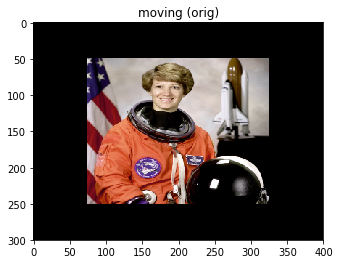

In [6]:
SAMP_SPACE = 2

# just like in MATLAB, this seems flipped?
# for ranges and grids: x is the columns and y is rows
x_range = np.arange(0, im_moving.shape[1] / SAMP_SPACE)
y_range = np.arange(0, im_moving.shape[0] / SAMP_SPACE)
xx, yy = np.meshgrid(x_range, y_range)

im_moving_sampled = im_moving[::SAMP_SPACE, ::SAMP_SPACE]

xin, yin = xx.flatten(), yy.flatten()

# list coordinates in input image
shift = np.array([xx.shape[1], xx.shape[0], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))

# list coordinates in input image
xy_in = np.array([xin, yin, np.ones(len(xin))])
xy_in = xy_in - shift

# apply inverse transform 
# # the grid is the same -> what gets transformed back
tform = aff_tfm.params
tform_inv = np.linalg.inv(aff_tfm.params)
tform_inv[0, 2] = tform_inv[0, 2] / SAMP_SPACE
tform_inv[1, 2] = tform_inv[1, 2] / SAMP_SPACE
xy_out = np.dot(tform_inv, xy_in).T
xy_out = xy_out + shift.T

x_out = np.expand_dims(xy_out[:, 0], 1), 
y_out = np.expand_dims(xy_out[:, 1], 1)

# something like coord??
xy_out_grid = np.zeros((2, xx.shape[0], yy.shape[1]))
xy_out_grid[0] = np.reshape(y_out, (xx.shape[0], yy.shape[1]))
xy_out_grid[1] = np.reshape(x_out, (xx.shape[0], yy.shape[1]))

im_new = skimage.transform.warp(
    im_moving_sampled[:,:,0] / 255.0, xy_out_grid,
    order=3, preserve_range=True, mode='constant',
    clip=True
)

# im_new = im_new / im_new.max()
im_new = np.clip(im_new, 0, 1)
im_new = np.uint8(255 * im_new)

plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()

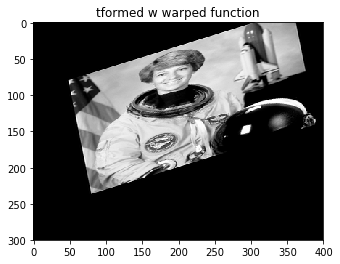

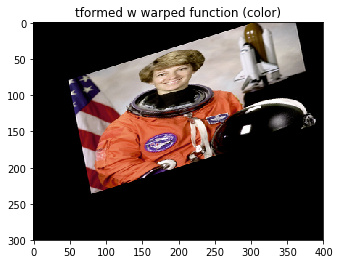

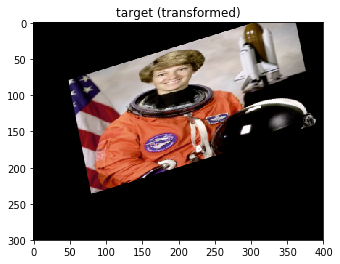

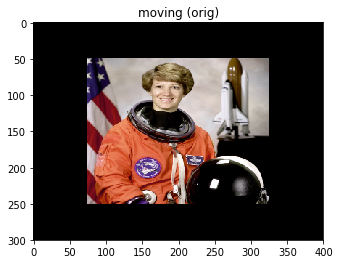

In [7]:

# here xy_out comes from the inverse mapping (and not regular)
dxy = xy_out - xy_in.T
dx, dy = dxy[:, 0], dxy[:, 1]

# dy = np.zeros([10, 1])

# pad image (post resizing)
im_orig = im_moving_sampled[:, :, 0]

im_int = register.image_interp_warp(im_moving_sampled[:,:,0], dx, dy)
im_int_color = register.image_interp_warp(im_moving_sampled, dx, dy)

plt.figure(1)
plt.title('tformed w warped function')
plt.imshow(im_int, cmap='gray')

plt.figure(2)
plt.title('tformed w warped function (color)')
plt.imshow(im_int_color)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)

plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()

In [18]:
im_int_color.min()

0